# Efficient numerical integration via composite and Gaussian quadrature rules

_(Jupyter notebook by Simone Brugiapaglia)_

In this notebook we will illustrate numerical integration via composite and Gaussian quadrature rules.

For more details, see Chapter 21 of 

*Q. Kong, T. Siauw, and A. M. Bayen. Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Academic Press, 2021. (https://pythonnumericalmethods.berkeley.edu/)*

and Sections 4.3, 4.4 and 4.7 of

*Richard L. Burden, J. Douglas Faires and Annette M. Burden. Numerical Analysis (10th Edition). Cengage, 2016.*

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Composite trapezoidal rule

We start by testing the composite trapezoidal rule. Given an equispaced grid $a = x_0 < x_1 < \cdots < x_n =b$ of stepsize $h>0$, the composite trapezoidal rule is given by
$$
\int_a^b f(x) \mathrm{d}x = \frac{h}{2} \left(f(a) +2 \sum_{j = 1}^{n-2} f(x_j) + f(b)\right) + O(h^2).
$$
First, we create a function `comp_trap` that implements this rule.

In [2]:
def comp_trap(f,a,b,h):
    """
    Composite trapezoidal rule
    """
    x_int = np.arange(a+h, b, h) # internal grid points
    n = round((b-a)/h) # compute parameter n
    return h/2 * (f(a) + 2 * np.sum(f(x_int[0:n])) + f(b)) # restriction x_int[0:n] improves formula's stability

We consider the test function 
$$f(x) = \log(x^2).$$
We compare the approximation of its integral over $[1,3]$ given by the composite trapezoidal rule with the ground truth value $\int_1^3 \log(x^2) \mathrm{d}x = \log(729)-4$ for different values of $h$ and check that the approximation error is $O(h^2)$ through a convergence plot.

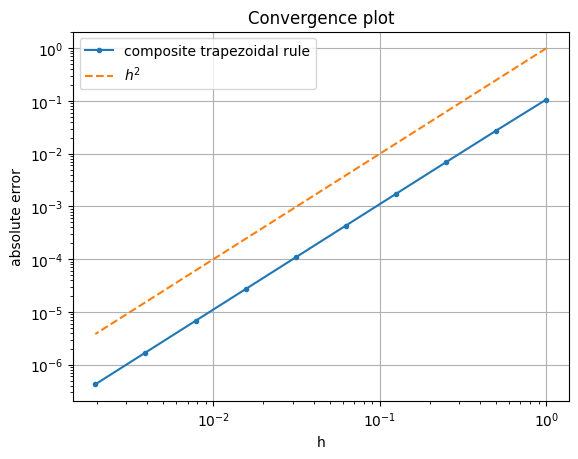

In [3]:
# define f, a, b
f = lambda x: np.log(x**2)
a = 1
b = 3

# grid of h values
h_vals = 2.0**(-np.arange(10))

# Initialize arrays to store approximation errors
Err_vals_trap = np.array([], dtype=np.int64).reshape(0,1)

# True value of the integral
I_true = np.log(729)-4

# repeat steps made above for different values of h
i_h = 0
for h in h_vals:
    I_trap = comp_trap(f,a,b,h)
    Err_vals_trap = np.vstack((Err_vals_trap, np.max(np.abs(I_trap - I_true))))


# visualize convergence plot
plt.loglog(h_vals, Err_vals_trap, '.-', label = 'composite trapezoidal rule')
plt.loglog(h_vals, h_vals**2, '--', label = '$h^2$')
plt.grid()
plt.xlabel('h')
plt.ylabel('absolute error')
plt.legend()
plt.title('Convergence plot')

plt.show()

## Comparison of composite trapezoidal, midpoint, and Simposon's rules

Let's compare different composite quadrature rules. Recall that the composite midpoint rule is given by
$$
\int_a^b f(x) \mathrm{d}x = h \sum_{j = 0}^{n-1} f\left(\frac{x_{j}+x_{j+1}}{2}\right)+ O(h^2),
$$
whereas the composite Simpson's rule is 
$$
\int_a^b f(x) \mathrm{d}x = \frac{h}{6} \left[f(a) +2 \sum_{j = 1}^{n-1} f(x_{j}) + 4 \sum_{j = 0}^{n-1} f\left(\frac{x_{j}+x_{j+1}}{2}\right) + f(b)\right] +O(h^4).
$$
Note that this formulas are presented in the textbook in a slighlty different form. You can show that these and the textbook's formulas are equivalent by a change of variable (try this!). First, we implement these quadrature rules in Python.

In [4]:
def comp_midp(f,a,b,h):
    """
    Composite midpoint rule
    """
    return h * np.sum( f(np.arange(a+h/2, b, h)) )

def comp_Simp(f,a,b,h):
    """
    Composite Simpson's rule
    """
    x_mid = np.arange(a+h/2, b, h) # midpoints
    x_int = np.arange(a+h, b, h) # internal grid points
    n = round((b-a)/h) # compute parameter n
    return h/6 * ( f(a) + 2 * np.sum ( f(x_int[0:n-1]) ) + 4 * np.sum( f(x_mid[0:n]) ) + f(b) )

Now, we compare them with a convergence plot using the same test funciton as before.

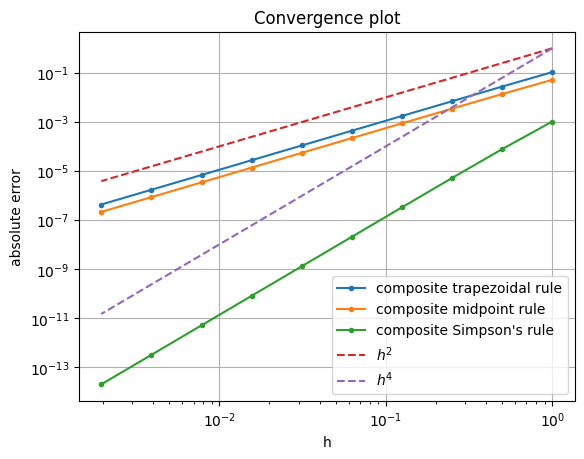

In [5]:
# Initialize arrays to store approximation errors
Err_vals_midp = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_Simp = np.array([], dtype=np.int64).reshape(0,1)

# repeat steps made above for different values of h
for h in h_vals:
    I_midp = comp_midp(f,a,b,h)
    I_Simp = comp_Simp(f,a,b,h)
    
    Err_vals_midp = np.vstack((Err_vals_midp, np.max(np.abs(I_midp - I_true))))
    Err_vals_Simp = np.vstack((Err_vals_Simp, np.max(np.abs(I_Simp - I_true))))


# visualize convergence plot
plt.loglog(h_vals, Err_vals_trap, '.-', label = 'composite trapezoidal rule')
plt.loglog(h_vals, Err_vals_midp, '.-', label = 'composite midpoint rule')
plt.loglog(h_vals, Err_vals_Simp, '.-', label = 'composite Simpson\'s rule')
plt.loglog(h_vals, h_vals**2, '--', label = '$h^2$')
plt.loglog(h_vals, h_vals**4, '--', label = '$h^4$')
plt.grid()
plt.xlabel('h')
plt.ylabel('absolute error')
plt.legend()
plt.title('Convergence plot')

plt.show()

As predicted by the theory, the composite trapezoidal and midpoint rules have comparable accuracy, whereas the composite Simpson's rule's convergence is considerably faster. The convergence rates $O(h^2)$ and $O(h^4)$ are observed numerically.

## Gaussian quadrature rules... rule!

We conclude by illustrating how to perform Gaussian quadrature in Python. For this purpose, we will use the built-in function `fixed_quad` from the `scipy.integrate` module. First, we numerically verify that an $n$-point Gaussian rule has degree of precision $2n-1$. With this aim, we numerically integrate monomials $x^k$ for increasing degree $k =0,1,2,...$ on $[0,1]$ and compute the corresponding approximation error.

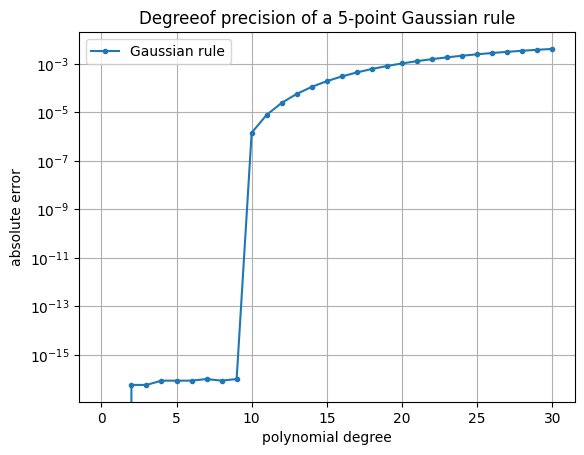

In [6]:
from scipy.integrate import fixed_quad 

deg_vals = np.arange(0,31)
n_order = 5

# Initialize arrays to store approximation errors
Err_vals_Gauss = np.array([], dtype=np.int64).reshape(0,1)

# repeat steps made above for different values of h
for deg in deg_vals:
    monomial = lambda x: x**deg
    I_Gauss, dummy = fixed_quad(monomial, 0, 1, n = n_order)
    Err_vals_Gauss = np.vstack((Err_vals_Gauss, np.max(np.abs(I_Gauss - 1/(deg+1)))))


# visualize convergence plot
plt.semilogy(deg_vals, Err_vals_Gauss, '.-', label = 'Gaussian rule')
plt.grid()
plt.xlabel('polynomial degree')
plt.ylabel('absolute error')
plt.legend()
plt.title('Degreeof precision of a '+str(n_order)+'-point Gaussian rule')

plt.show()

As predicted by the theory, an $n$-point Gaussian quadrature rule has degree of precision $2n-1$. Notably, the Gaussian rule can integrate monomials $x^k$ with $k > 2n-1$ (i.e., beyond its degree of precision) quite well, albeit not exactly.

We conclude by comparing the $n$-point Gaussian rule with composite Simpson's rule of stepsize $h = (b-a)/n$.

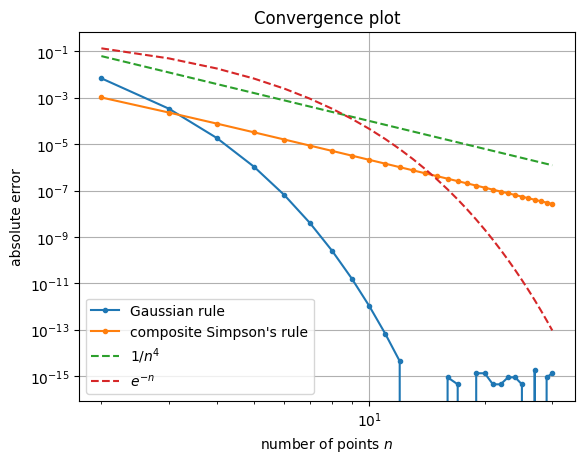

In [7]:
from scipy.integrate import fixed_quad 

n_vals = np.arange(2,31)

# Initialize arrays to store approximation errors
Err_vals_Simp  = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_Gauss = np.array([], dtype=np.int64).reshape(0,1)


# repeat steps made above for different values of h
for n_val in n_vals:
    I_Simp = comp_Simp(f,a,b,(b-a)/n_val)
    I_Gauss, dummy = fixed_quad(f, a, b, n = n_val)

    Err_vals_Simp  = np.vstack((Err_vals_Simp, np.max(np.abs(I_Simp - I_true))))
    Err_vals_Gauss = np.vstack((Err_vals_Gauss, np.max(np.abs(I_Gauss - I_true))))


# visualize convergence plot
plt.loglog(n_vals, Err_vals_Gauss, '.-', label = 'Gaussian rule')
plt.loglog(n_vals, Err_vals_Simp, '.-', label = 'composite Simpson\'s rule')
plt.loglog(n_vals, 1/n_vals**4, '--', label = '$1/n^4$')
plt.loglog(n_vals,  np.exp(-n_vals), '--', label = '$e^{-n}$')
plt.grid()
plt.xlabel('number of points $n$')
plt.ylabel('absolute error')
plt.legend()
plt.title('Convergence plot')

plt.show()

Gaussian quadrature is much more accurate that composite Simpson's rule! In fact, its approximation error goes to zero exponentially fast in $n$.

## Recommended problems

- Try to find functions for which Gaussian quadrature is not very accurate and compare it with composite rules in these cases (Hint: consider functions that are not very regular, e.g., discontinuous functions).
- Solve Problem 5 in Chapter 21 of
  
  *Q. Kong, T. Siauw, and A. M. Bayen. Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Academic Press, 2021. (https://pythonnumericalmethods.berkeley.edu/)*